In [2]:
from torch.utils.data import Dataset
from os import listdir
from os.path import isfile, join
from matplotlib import pyplot as plt
import matplotlib.patches as patches

import json
import cv2
import numpy as np

In [3]:
def getMASKfromJSON(json):
    smallMask = json['mask']
    mask = np.zeros((512,512),dtype='int')
    print(json['minY'],len(smallMask))
    for y in range(len(smallMask)):
        for x in range(len(smallMask[0])):
            mask[json['minY']+y,json['minX']+x] = smallMask[y][x]
    return(mask)

In [4]:
class SegmentationDataset(Dataset):
	def __init__(self, imagePath, maskPath, transforms=None):
		# store the image and mask filepaths, and augmentation
		# transforms
		self.imageFiles = [f for f in listdir(imagePath) if isfile(join(imagePath, f))]
		self.imagePath = imagePath
		self.maskFiles = [f for f in listdir(maskPath) if isfile(join(maskPath, f))]
		self.maskPath = maskPath
		self.transforms = transforms
	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.imageFiles)
	def __getitem__(self, idx):
			#imageFileName = self.maskFiles[idx][:-4]+'.png'
		outFileName = self.imageFiles[idx][:-3]+'out'
		# grab the image path from the current index
			#imagePath = join(self.imagePath,imageFileName)
		imagePath = join(self.imagePath,self.imageFiles[idx])
		# Return RGB of image
		image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		#Creating the mask
			#f = open(join(self.maskPath,self.maskFiles[idx]))
		f = open(join(self.maskPath,outFileName))
		json_load = json.load(f)
		mask = getMASKfromJSON(json_load)
		f.close()
		return {'image': image, 'segmentation_mask': mask}
	def getMasks(self):
		return self.maskFiles

In [5]:
def getMaxAndMin(points):
    minX = 513
    minY = 513
    maxX = -1
    maxY = -1
    for point in points:
        if point[0] > maxX:
            maxX = point[0]
        if point[0] < minX:
            minX = point[0]
        if point[1] > maxY:
            maxY = point[1]
        if point[1] < minY:
            minY = point[1]
    return((minX,minY,maxX,maxY))

def displayImageWithRectangle(image,rectangle):
    _, ax = plt.subplots()
    rect = patches.Rectangle((rectangle[0],rectangle[1]), rectangle[2]-rectangle[0],rectangle[3]-rectangle[1], linewidth=1, edgecolor='r', facecolor='none')
    ax.imshow(image)
    ax.add_patch(rect) 

205 75


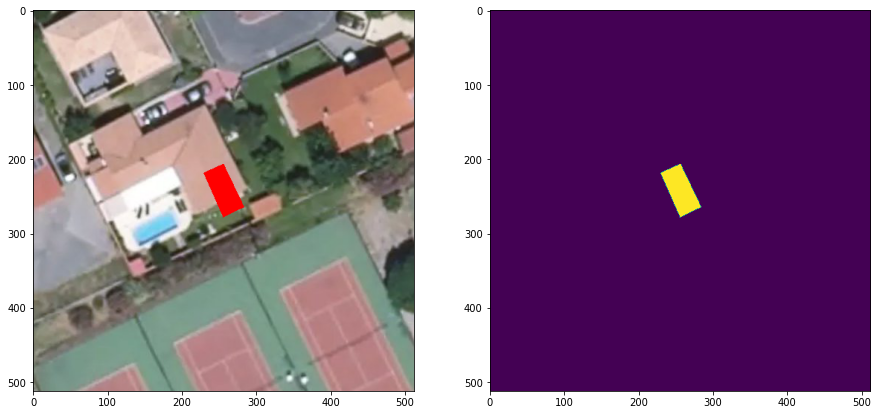

In [15]:
data = SegmentationDataset('Images/train','Images/masks')

d = data[3]
image = d['image']
mask = d['segmentation_mask']

#CODE TO SUPERPOSE
for i in range(512):
    for j in range(512):
        if mask[i,j] == 1:
            image[i,j] = [255,0,0]

fig = plt.figure(figsize=(15,15))
fig.add_subplot(1,2,1)
plt.imshow(image)
fig.add_subplot(1,2,2)
plt.imshow(mask)




# fJSON = open('metadata.json')
# maskJSON = json.load(fJSON)
# points = []
# for point in maskJSON[imageName]['bounds_x_y']:
# 	points.append((point['x'],point['y']))
# maxMin = getMaxAndMin(points)

# displayImageWithRectangle(image,maxMin)


Tensorflow Approach

In [21]:
import tensorflow as tf
from IPython.display import clear_output

import tensorflow_datasets as tfds

In [23]:
class MyDataset(tfds.core.GeneratorBasedBuilder):
  """DatasetBuilder for my_dataset dataset."""

  VERSION = tfds.core.Version('1.0.0')
  RELEASE_NOTES = {
      '1.0.0': 'Initial release.',
  }

  def _info(self) -> tfds.core.DatasetInfo:
    """Dataset metadata (homepage, citation,...)."""
    return tfds.core.DatasetInfo(
        builder=self,
        features=tfds.features.FeaturesDict({
            'image': tfds.features.Image(shape=(256, 256, 3)),
            'label': tfds.features.ClassLabel(
                names=['no', 'yes'],
                doc='Whether this is a picture of a cat'),
        }),
    )

  def _split_generators(self, dl_manager: tfds.download.DownloadManager):
    """Download the data and define splits."""
    extracted_path = dl_manager.download_and_extract('http://data.org/data.zip')
    # dl_manager returns pathlib-like objects with `path.read_text()`,
    # `path.iterdir()`,...
    return {
        'train': self._generate_examples(path=extracted_path / 'train_images'),
        'test': self._generate_examples(path=extracted_path / 'test_images'),
    }

  def _generate_examples(self, path) -> Iterator[Tuple[Key, Example]]:
    """Generator of examples for each split."""
    for img_path in path.glob('*.jpeg'):
      # Yields (key, example)
      yield img_path.name, {
          'image': img_path,
          'label': 'yes' if img_path.name.startswith('yes_') else 'no',
      }

NameError: name 'Iterator' is not defined

In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask
  
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [13]:
train_images = SegmentationDataset('images','masks')

In [14]:
TRAIN_LENGTH = len(train_images)
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [16]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [18]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))


AttributeError: 